In [50]:
import os
from typing import Annotated, Sequence, TypedDict, List
import logging

logging.basicConfig(level=logging.INFO)

from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from qdrant_client import QdrantClient

load_dotenv()
collection_name = 'prawo_wodne'

def vectorize_user_query(query: str) -> List[float]:
    embedder = NVIDIAEmbeddings(model = os.environ["EMBEDDER"])
    return embedder.embed_query(query)

@tool
def retrive_data_from_db(user_query: str) -> str:
    """Using user query input returns data from vector database as a list of a string documents. 
    The list is used for chatbot answer."""

    client = QdrantClient(url='http://localhost:6333')
    response = client.query_points(
        collection_name=collection_name,
        query=vectorize_user_query(query=user_query),
        limit=5,
        with_payload=True,
    )
    logging.info(response)
    if not response:
        return "Nie znalazłem dokumentów odpowiednich do zadanego pytania"
    return "\n".join([i.payload['content']['page_content'] for i in response.points])

In [51]:
text = "Witaj, co obejmują instrumenty zarządzania zasobami wodnymi?"

In [52]:
retrive_data_from_db.invoke(text)

INFO:httpx:HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:6333/collections/prawo_wodne/points/query "HTTP/1.1 200 OK"
INFO:root:points=[ScoredPoint(id=29, version=29, score=0.7104428, payload={'content': {'metadata': {'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-01-24T10:08:08+01:00', 'title': 'Akt prawny', 'author': 'Władysław Baksza', 'moddate': '2024-01-24T10:08:08+01:00', 'source': './files/prawod_wodne.pdf', 'total_pages': 444}, 'page_content': 'wykorzystania wód; \n7) zaspokojenia potrzeb związanych z turystyką, sportem oraz rekreacją. \nArt. 11. Instrumenty zarządzania zasobami wodnymi obejmują: \n1) planowanie w gospodarowaniu wodami; \n2) zgody wodnoprawne; \n3) opłaty za usługi wodne oraz inne należności;'}}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=1757, version=1757, score=0.60761607, payload={'content': {'metadata': {'producer': 'Microsoft® Word 2

'wykorzystania wód; \n7) zaspokojenia potrzeb związanych z turystyką, sportem oraz rekreacją. \nArt. 11. Instrumenty zarządzania zasobami wodnymi obejmują: \n1) planowanie w gospodarowaniu wodami; \n2) zgody wodnoprawne; \n3) opłaty za usługi wodne oraz inne należności;\nInstrumenty ekonomiczne w gospodarowaniu wodami \nArt. 267. Instrumenty ekonomiczne służące gospodarowaniu wodami \nstanowią: \n1) opłaty za usługi wodne; \n2) opłaty podwyższone; \n3) należności za korzystanie ze śródlądowych dróg wodnych i ich odcinków oraz\nz uwzględnieniem zasady zwrotu kosztów usług wodnych oraz długoterminowych \nprognoz dotyczących możliwości zaspokojenia potrzeb w  zakresie korzystania \nz zasobów wodnych na obszarz e dorzecza obejmujących śródlądowe wody \npowierzchniowe i  wody podziemne, morskie wody wewnętrzne oraz wody\n3) opłaty za usługi wodne oraz inne należności; \n4) kontrolę gospodarowania wodami; \n5) system informacyjny gospodarowania wodami. \nArt. 12. Zarządzanie zasobami wodnymi

In [70]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph.message import add_messages

class RagState(TypedDict):
    message: Annotated[Sequence[BaseMessage], add_messages]
    context: Annotated[Sequence[BaseMessage], add_messages]

model = ChatNVIDIA(model=os.environ["LLM"], temprature = 0).bind_tools([retrive_data_from_db])

GENERATE_PROMPT = (
    "Jesteś botem odpowiadającym na zapytania użytkownika na podstawie dokumentu prawa wodnego. "
    "Użytkonwik zapytał: {question}\n "
    "Z jego pytania udało się nam uzyskać następujące dokumenty z bazy danych "
    "Document z bazy:\n{context}\n\n "
    "(Odpowiedz tylko na podstawie dokumentów) "
)

def generate_query_context(state: RagState) -> RagState:
    logging.info("generating query context")
    logging.info(state['message'])
    response = model.invoke(state['message'])
    state['context'] = response
    logging.info(state['context'])
    return state

def generate_user_answer(state: RagState) -> RagState:
    logging.info("generating user answer")
    prompt = GENERATE_PROMPT.format(question=state["message"], context=state["context"])
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"message": [response]}

In [71]:
input = {"message": "Witaj, co obejmują instrumenty zarządzania zasobami wodnymi?"}
result = generate_query_context(input)
result

INFO:root:generating query context
INFO:root:Witaj, co obejmują instrumenty zarządzania zasobami wodnymi?
INFO:root:content='' additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb', 'type': 'function', 'function': {'name': 'retrive_data_from_db', 'arguments': '{"user_query": "Instrumenty zarz\\u0105dzania zasobami wodnymi"}'}}]} response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb', 'type': 'function', 'function': {'name': 'retrive_data_from_db', 'arguments': '{"user_query": "Instrumenty zarz\\u0105dzania zasobami wodnymi"}'}}], 'token_usage': {'prompt_tokens': 319, 'total_tokens': 346, 'completion_tokens': 27}, 'finish_reason': 'tool_calls', 'model_name': 'meta/llama-3.1-8b-instruct'} id='run--7a3cc9d5-a7de-4e29-8aaa-e48f68d48490-0' tool_calls=[{'name': 'retrive_data_from_db', 'args': {'user_query': 'Instrumenty zarządzania zasobami wodnymi'}, 'id': 'chatcmpl-tool-7d985bfbf0d9

{'message': 'Witaj, co obejmują instrumenty zarządzania zasobami wodnymi?',
 'context': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb', 'type': 'function', 'function': {'name': 'retrive_data_from_db', 'arguments': '{"user_query": "Instrumenty zarz\\u0105dzania zasobami wodnymi"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb', 'type': 'function', 'function': {'name': 'retrive_data_from_db', 'arguments': '{"user_query": "Instrumenty zarz\\u0105dzania zasobami wodnymi"}'}}], 'token_usage': {'prompt_tokens': 319, 'total_tokens': 346, 'completion_tokens': 27}, 'finish_reason': 'tool_calls', 'model_name': 'meta/llama-3.1-8b-instruct'}, id='run--7a3cc9d5-a7de-4e29-8aaa-e48f68d48490-0', tool_calls=[{'name': 'retrive_data_from_db', 'args': {'user_query': 'Instrumenty zarządzania zasobami wodnymi'}, 'id': 'chatcmpl-tool-7d985bfbf0d94501bb19cffb9a

In [72]:
result['context'].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrive_data_from_db (chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb)
 Call ID: chatcmpl-tool-7d985bfbf0d94501bb19cffb9a9dd4bb
  Args:
    user_query: Instrumenty zarządzania zasobami wodnymi


In [56]:
from langgraph.prebuilt import tools_condition

graph = StateGraph(RagState)

graph.add_node(generate_query_context)
graph.add_node("retrieve", ToolNode([retrive_data_from_db]))
graph.add_node(generate_user_answer)

graph.add_edge(START, "generate_query_context")
graph.add_conditional_edges(
    "generate_query_context",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)
graph.add_edge("retrieve", "generate_user_answer")
graph.add_edge("generate_user_answer", END)

agent = graph.compile()

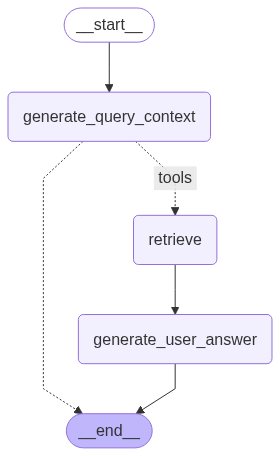

In [60]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [78]:
[m for m in ChatNVIDIA.get_available_models() if m.supports_tools]

[Model(id='meta/llama-3.3-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='meta/llama-3.1-8b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='meta/llama-3.1-405b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='meta/llama-3.2-3b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='mistralai/mistral-large-2-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='meta/llama-3.1-70b-instruct', model_type='chat', client='ChatNVIDIA', end